In [1]:
# !pip install torch_geometric==2.3.1

In [2]:
import argparse
import os.path as osp
from typing import Any, Dict, Optional

from tqdm import tqdm

import torch
from torch.nn import (
    BatchNorm1d,
    Embedding,
    Linear,
    ModuleList,
    ReLU,
    Sequential,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_add_pool
import inspect
from typing import Any, Dict, Optional

import torch.nn.functional as F
from torch import Tensor
from torch.nn import Dropout, Linear, Sequential

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset
from torch_geometric.nn.resolver import (
    activation_resolver,
    normalization_resolver,
)
from torch_geometric.typing import Adj
from torch_geometric.utils import to_dense_batch

from mamba_ssm import Mamba
from torch_geometric.utils import degree, sort_edge_index

from pytorch_lightning import seed_everything

/home/guillem/anaconda3/envs/L65/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def permute_within_batch(x, batch):
    # Enumerate over unique batch indices
    unique_batches = torch.unique(batch)
    
    # Initialize list to store permuted indices
    permuted_indices = []

    for batch_index in unique_batches:
        # Extract indices for the current batch
        indices_in_batch = (batch == batch_index).nonzero().squeeze()
        
        # Permute indices within the current batch
        permuted_indices_in_batch = indices_in_batch[torch.randperm(len(indices_in_batch))]
        
        # Append permuted indices to the list
        permuted_indices.append(permuted_indices_in_batch)
    
    # Concatenate permuted indices into a single tensor
    permuted_indices = torch.cat(permuted_indices)

    return permuted_indices

In [41]:
# path, subset = '/scratch/ssd004/scratch/tsepaole/ZINC_full/', False
path, subset = '', True

transform = T.AddRandomWalkPE(walk_length=20, attr_name='pe')
train_dataset = ZINC(path, subset=subset, split='train', pre_transform=transform)
val_dataset = ZINC(path, subset=subset, split='val', pre_transform=transform)
test_dataset = ZINC(path, subset=subset, split='test', pre_transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [113]:
def heuristic_degree(bidirectional=True):
    def heuristic(x, pe, edge_index, edge_attr, batch):
        deg = degree(edge_index[0], x.shape[0]).to(torch.long)
        if bidirectional:
            return [deg, -deg]
        return 
    return heuristic, 2 if bidirectional else 1

def heuristic_laplacian(num_coefficients=1, bidirectional=True):
    def heuristic(x, pe, edge_index, edge_attr, batch):
        result = []
        for _ in range(num_coefficients):
            result.append(x)
            if bidirectional:
                result.append(reversed(x))
        return result
    return heuristic, num_coefficients*(2 if bidirectional else 1)

In [114]:
class GPSConv(torch.nn.Module):

    def __init__(
        self,
        channels: int,
        conv: Optional[MessagePassing],
        heads: int = 1,
        dropout: float = 0.0,
        attn_dropout: float = 0.0,
        act: str = 'relu',
        att_type: str = 'transformer',
        order_by_degree: bool = False,
        heuristics: list = [],
        shuffle_ind: int = 0,
        d_state: int = 16,
        d_conv: int = 4,
        act_kwargs: Optional[Dict[str, Any]] = None,
        norm: Optional[str] = 'batch_norm',
        norm_kwargs: Optional[Dict[str, Any]] = None,
    ):
        super().__init__()

        self.channels = channels
        self.conv = conv
        self.heads = heads
        self.dropout = dropout
        self.att_type = att_type
        self.shuffle_ind = shuffle_ind
        self.order_by_degree = order_by_degree
        self.heuristic_fns = []
        
        assert (self.order_by_degree==True and self.shuffle_ind==0) or (self.order_by_degree==False), f'order_by_degree={self.order_by_degree} and shuffle_ind={self.shuffle_ind}'
        
        if self.att_type == 'transformer':
            self.attn = torch.nn.MultiheadAttention(
                channels,
                heads,
                dropout=attn_dropout,
                batch_first=True,
            )
        if self.att_type == 'mamba':
            if len(heuristics) == 0:
                self.att_type = "mamba-old"
                self.self_attn = Mamba(
                    d_model=channels,
                    d_state=d_state,
                    d_conv=d_conv,
                    expand=1
                )
            else:
                self.self_attn = ModuleList()
                for heuristic_fn, return_sequences_num in heuristics:
                    self.heuristic_fns.append(heuristic_fn)
                    for _ in range(return_sequences_num):
                        self.self_attn.append(Mamba(
                            d_model=channels,
                            d_state=d_state,
                            d_conv=d_conv,
                            expand=1
                        ))
            
        self.mlp = Sequential(
            Linear(channels, channels * 2),
            activation_resolver(act, **(act_kwargs or {})),
            Dropout(dropout),
            Linear(channels * 2, channels),
            Dropout(dropout),
        )

        norm_kwargs = norm_kwargs or {}
        self.norm1 = normalization_resolver(norm, channels, **norm_kwargs)
        self.norm2 = normalization_resolver(norm, channels, **norm_kwargs)
        self.norm3 = normalization_resolver(norm, channels, **norm_kwargs)

        self.norm_with_batch = False
        if self.norm1 is not None:
            signature = inspect.signature(self.norm1.forward)
            self.norm_with_batch = 'batch' in signature.parameters

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        if self.conv is not None:
            self.conv.reset_parameters()
        self.attn._reset_parameters()
        reset(self.mlp)
        if self.norm1 is not None:
            self.norm1.reset_parameters()
        if self.norm2 is not None:
            self.norm2.reset_parameters()
        if self.norm3 is not None:
            self.norm3.reset_parameters()

    def forward(
        self,
        x: Tensor,
        edge_index: Adj,
        batch: Optional[torch.Tensor] = None,
        **kwargs,
    ) -> Tensor:
        r"""Runs the forward pass of the module."""
        hs = []
        if self.conv is not None:  # Local MPNN.
            h = self.conv(x, edge_index, **kwargs)
            h = F.dropout(h, p=self.dropout, training=self.training)
            h = h + x
            if self.norm1 is not None:
                if self.norm_with_batch:
                    h = self.norm1(h, batch=batch)
                else:
                    h = self.norm1(h)
            hs.append(h)

        ### Global attention transformer-style model.
        if self.att_type == 'transformer':
            h, mask = to_dense_batch(x, batch)
            h, _ = self.attn(h, h, h, key_padding_mask=~mask, need_weights=False)
            h = h[mask]
            
        if self.att_type == 'mamba-old':
            
            if self.order_by_degree:
                deg = degree(edge_index[0], x.shape[0]).to(torch.long)
                order_tensor = torch.stack([batch, deg], 1).T
                _, x = sort_edge_index(order_tensor, edge_attr=x)
                
            if self.shuffle_ind == 0:
                h, mask = to_dense_batch(x, batch)
                h = self.self_attn(h)[mask]
            else:
                mamba_arr = []
                for _ in range(self.shuffle_ind):
                    h_ind_perm = permute_within_batch(x, batch)
                    h_i, mask = to_dense_batch(x[h_ind_perm], batch)
                    h_i = self.self_attn(h_i)[mask][h_ind_perm]
                    mamba_arr.append(h_i)
                h = sum(mamba_arr) / self.shuffle_ind
            
        if self.att_type == 'mamba':

            xs = []
            for heuristic in self.heuristic_fns:
                heuristic_xs = heuristic(x, batch, edge_index)
                xs += heuristic_xs
            
            mamba_arr = []
            for j, x_ in enumerate(xs):
                h_i, mask = to_dense_batch(x_, batch)
                h_i = self.self_attn[j](h_i)[mask]
                mamba_arr.append(h_i)

            h = sum(mamba_arr) / len(xs)
        ###
        
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = h + x  # Residual connection.
        if self.norm2 is not None:
            if self.norm_with_batch:
                h = self.norm2(h, batch=batch)
            else:
                h = self.norm2(h)
        hs.append(h)

        out = sum(hs)  # Combine local and global outputs.

        out = out + self.mlp(out)
        if self.norm3 is not None:
            if self.norm_with_batch:
                out = self.norm3(out, batch=batch)
            else:
                out = self.norm3(out)

        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.channels}, '
                f'conv={self.conv}, heads={self.heads})')

In [115]:
class GraphModel(torch.nn.Module):
    def __init__(self, channels: int, pe_dim: int, num_layers: int, model_type: str, shuffle_ind: int, d_state: int, d_conv: int, order_by_degree: False, heuristics=[]):
        super().__init__()

        self.node_emb = Embedding(28, channels - pe_dim)
        self.pe_lin = Linear(20, pe_dim)
        self.pe_norm = BatchNorm1d(20)
        self.edge_emb = Embedding(4, channels)
        self.model_type = model_type
        self.shuffle_ind = shuffle_ind
        self.order_by_degree = order_by_degree
        self.heuristic_fns = []
        self.heuristics_num = 0 
        for heuristic_fn, return_sequences_num in heuristics:
            self.heuristic_fns.append(heuristic_fn)
            self.heuristics_num = return_sequences_num
        
        self.convs = ModuleList()
        for _ in range(num_layers):
            nn = Sequential(
                Linear(channels, channels),
                ReLU(),
                Linear(channels, channels),
            )
            if self.model_type == 'gine':
                conv = GINEConv(nn)
                
            if self.model_type == 'mamba':
                conv = GPSConv(channels, GINEConv(nn), heads=4, attn_dropout=0.5,
                               att_type='mamba',
                               shuffle_ind=self.shuffle_ind,
                               order_by_degree=self.order_by_degree,
                               heuristics_num=heuristics_num,
                               d_state=d_state, d_conv=d_conv)
                
            if self.model_type == 'transformer':
                conv = GPSConv(channels, GINEConv(nn), heads=4, attn_dropout=0.5, att_type='transformer')
                
            # conv = GINEConv(nn)
            self.convs.append(conv)

        self.mlp = Sequential(
            Linear(channels, channels // 2),
            ReLU(),
            Linear(channels // 2, channels // 4),
            ReLU(),
            Linear(channels // 4, 1),
        )

    def forward(self, x, pe, edge_index, edge_attr, batch):
        x_pe = self.pe_norm(pe)
        x = torch.cat((self.node_emb(x.squeeze(-1)), self.pe_lin(x_pe)), 1)
        edge_attr = self.edge_emb(edge_attr)

        heuristics = []
        for heuristic in self.heuristic_fns:
            h = heuristic(x, pe, edge_index, edge_attr, batch)
            order_tensor = torch.stack([batch, h], 1).T
            heuristics.append(order_tensor)

        for conv in self.convs:
            if self.model_type == 'gine':
                x = conv(x, edge_index, edge_attr=edge_attr)
            elif self.model_type == 'mamba':
                x = conv(x, edge_index, batch, edge_attr=edge_attr, heuristics=heuristics)
            else:
                x = conv(x, edge_index, batch, edge_attr=edge_attr)
                
        x = global_add_pool(x, batch)
        return self.mlp(x)

In [96]:
def train():
    model.train()
    
    total_loss = 0
    for data in tqdm(train_loader, total=len(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.pe, data.edge_index, data.edge_attr,
                    data.batch)
        loss = (out.squeeze() - data.y).abs().mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        # print(loss.item())
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [97]:
@torch.no_grad()
def test(loader):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        # print(data.x.shape)
        out = model(data.x, data.pe, data.edge_index, data.edge_attr,
                    data.batch)
        total_error += (out.squeeze() - data.y).abs().sum().item()
        # print(data.x.isnan().sum()+data.pe.isnan().sum()+data.edge_index.isnan().sum()+data.edge_attr.isnan().sum()+data.batch.isnan().sum())
        # print(out.squeeze(), data.y)
        # print((out.squeeze() - data.y).abs().sum().item())
        # print()
    return total_error / len(loader.dataset)

In [9]:
# it.to(device)

In [13]:
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphModel(channels=64, pe_dim=8, num_layers=10,
                   model_type='mamba',
                   shuffle_ind=0, order_by_degree=True,
                   d_conv=4, d_state=16,
                  ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)
arr = []
for epoch in range(1, 30):
    loss = train()
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')
    arr.append(test_mae)
ordering = arr
print(ordering)

100%|██████████| 313/313 [00:25<00:00, 12.11it/s]


Epoch: 01, Loss: 0.7150, Val: 0.5494, Test: 0.5997


100%|██████████| 313/313 [00:25<00:00, 12.21it/s]


Epoch: 02, Loss: 0.6122, Val: 0.7392, Test: 0.7644


100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch: 03, Loss: 0.5605, Val: 0.5302, Test: 0.5540


100%|██████████| 313/313 [00:18<00:00, 16.82it/s]


Epoch: 04, Loss: 0.5267, Val: 0.4714, Test: 0.4841


100%|██████████| 313/313 [00:17<00:00, 17.69it/s]


Epoch: 05, Loss: 0.5068, Val: 0.6031, Test: 0.5710


100%|██████████| 313/313 [00:18<00:00, 16.78it/s]


Epoch: 06, Loss: 0.5027, Val: 0.6516, Test: 0.6524


100%|██████████| 313/313 [00:15<00:00, 19.81it/s]


Epoch: 07, Loss: 0.4643, Val: 0.4983, Test: 0.4895


100%|██████████| 313/313 [00:17<00:00, 18.21it/s]


Epoch: 08, Loss: 0.4660, Val: 0.5225, Test: 0.5327


100%|██████████| 313/313 [00:18<00:00, 17.23it/s]


Epoch: 09, Loss: 0.4514, Val: 0.4935, Test: 0.4961


100%|██████████| 313/313 [00:19<00:00, 16.10it/s]


Epoch: 10, Loss: 0.4255, Val: 0.5721, Test: 0.5699


100%|██████████| 313/313 [00:20<00:00, 15.03it/s]


Epoch: 11, Loss: 0.4184, Val: 0.4846, Test: 0.4828


100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


Epoch: 12, Loss: 0.4132, Val: 0.3917, Test: 0.3487


100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


Epoch: 13, Loss: 0.4117, Val: 0.3894, Test: 0.4047


100%|██████████| 313/313 [00:18<00:00, 17.34it/s]


Epoch: 14, Loss: 0.4050, Val: nan, Test: nan


100%|██████████| 313/313 [00:17<00:00, 17.50it/s]


Epoch: 15, Loss: 0.3973, Val: 0.4923, Test: 0.4988


100%|██████████| 313/313 [00:17<00:00, 18.21it/s]


Epoch: 16, Loss: 0.3786, Val: nan, Test: nan


100%|██████████| 313/313 [00:16<00:00, 19.09it/s]


Epoch: 17, Loss: 0.3911, Val: 0.5341, Test: 0.5199


100%|██████████| 313/313 [00:16<00:00, 18.79it/s]


Epoch: 18, Loss: 0.3845, Val: 0.3414, Test: 0.3354


100%|██████████| 313/313 [00:16<00:00, 19.17it/s]


Epoch: 19, Loss: 0.3631, Val: nan, Test: nan


100%|██████████| 313/313 [00:16<00:00, 18.67it/s]


Epoch: 20, Loss: 0.3610, Val: nan, Test: nan


100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch: 21, Loss: 0.3713, Val: nan, Test: nan


100%|██████████| 313/313 [00:21<00:00, 14.53it/s]


Epoch: 22, Loss: 0.3552, Val: 0.4834, Test: 0.4993


100%|██████████| 313/313 [00:22<00:00, 13.66it/s]


Epoch: 23, Loss: 0.3504, Val: 0.4976, Test: nan


100%|██████████| 313/313 [00:22<00:00, 13.73it/s]


Epoch: 24, Loss: 0.3542, Val: nan, Test: nan


100%|██████████| 313/313 [00:20<00:00, 15.27it/s]


Epoch: 25, Loss: 0.3357, Val: nan, Test: nan


100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch: 26, Loss: 0.3339, Val: 0.5082, Test: nan


100%|██████████| 313/313 [00:20<00:00, 15.18it/s]


Epoch: 27, Loss: 0.3273, Val: nan, Test: nan


100%|██████████| 313/313 [00:23<00:00, 13.24it/s]


Epoch: 28, Loss: 0.3300, Val: nan, Test: nan


100%|██████████| 313/313 [00:28<00:00, 10.80it/s]


Epoch: 29, Loss: 0.3253, Val: nan, Test: nan
[0.5996598854064942, 0.7644245338439941, 0.5540183296203613, 0.48406396293640136, 0.5709599857330322, 0.652398078918457, 0.4895087661743164, 0.5327159786224365, 0.49606224822998046, 0.5698553123474122, 0.48284191513061525, 0.3486849994659424, 0.40469066619873045, nan, 0.49884879302978513, nan, 0.5198935852050781, 0.33538764572143553, nan, nan, nan, 0.4993139820098877, nan, nan, nan, nan, nan, nan, nan]


In [19]:
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphModel(channels=64, pe_dim=8, num_layers=10,
                   model_type='mamba',
                   shuffle_ind=1, order_by_degree=False,
                   d_conv=4, d_state=16,
                  ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)
arr = []
for epoch in range(1, 30):
    loss = train()
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')
    arr.append(test_mae)
permute = arr
print(permute)

100%|██████████| 313/313 [00:39<00:00,  7.97it/s]


Epoch: 01, Loss: 0.6607, Val: 0.5037, Test: 0.4943


100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


Epoch: 02, Loss: 0.5107, Val: 0.6301, Test: 0.6095


100%|██████████| 313/313 [00:58<00:00,  5.34it/s]


Epoch: 03, Loss: 0.4816, Val: 0.5877, Test: 0.5940


100%|██████████| 313/313 [00:45<00:00,  6.89it/s]


Epoch: 04, Loss: 0.4538, Val: 0.4258, Test: 0.4205


100%|██████████| 313/313 [00:43<00:00,  7.17it/s]


Epoch: 05, Loss: 0.4330, Val: 0.3683, Test: 0.3614


100%|██████████| 313/313 [00:47<00:00,  6.64it/s]


Epoch: 06, Loss: 0.4025, Val: 0.4856, Test: 0.4815


100%|██████████| 313/313 [00:53<00:00,  5.83it/s]


Epoch: 07, Loss: 0.3948, Val: 0.3819, Test: 0.3924


100%|██████████| 313/313 [00:46<00:00,  6.80it/s]


Epoch: 08, Loss: 0.3713, Val: 0.3909, Test: 0.3928


100%|██████████| 313/313 [00:38<00:00,  8.22it/s]


Epoch: 09, Loss: 0.3676, Val: 0.5833, Test: 0.5746


100%|██████████| 313/313 [00:35<00:00,  8.72it/s]


Epoch: 10, Loss: 0.3603, Val: 0.3486, Test: 0.3149


100%|██████████| 313/313 [00:37<00:00,  8.45it/s]


Epoch: 11, Loss: 0.3403, Val: 0.4026, Test: 0.3671


100%|██████████| 313/313 [00:45<00:00,  6.95it/s]


Epoch: 12, Loss: 0.3341, Val: 0.3967, Test: 0.3629


100%|██████████| 313/313 [00:43<00:00,  7.12it/s]


Epoch: 13, Loss: 0.3330, Val: 0.2782, Test: 0.2529


100%|██████████| 313/313 [00:42<00:00,  7.31it/s]


Epoch: 14, Loss: 0.3387, Val: 0.4724, Test: 0.4429


100%|██████████| 313/313 [00:38<00:00,  8.23it/s]


Epoch: 15, Loss: 0.3243, Val: 0.3276, Test: 0.3002


100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


Epoch: 16, Loss: 0.3113, Val: 0.3246, Test: 0.3013


100%|██████████| 313/313 [00:37<00:00,  8.29it/s]


Epoch: 17, Loss: 0.3146, Val: 0.2779, Test: 0.2507


100%|██████████| 313/313 [00:40<00:00,  7.80it/s]


Epoch: 18, Loss: 0.3180, Val: 0.4175, Test: 0.4021


100%|██████████| 313/313 [00:42<00:00,  7.37it/s]


Epoch: 19, Loss: 0.3089, Val: 0.5092, Test: 0.4915


100%|██████████| 313/313 [00:51<00:00,  6.10it/s]


Epoch: 20, Loss: 0.3061, Val: 0.3731, Test: 0.3395


100%|██████████| 313/313 [00:40<00:00,  7.65it/s]


Epoch: 21, Loss: 0.2984, Val: 0.3238, Test: 0.2998


100%|██████████| 313/313 [00:39<00:00,  7.87it/s]


Epoch: 22, Loss: 0.2956, Val: 0.2685, Test: 0.2370


100%|██████████| 313/313 [00:38<00:00,  8.15it/s]


Epoch: 23, Loss: 0.2950, Val: 0.4149, Test: 0.3945


100%|██████████| 313/313 [00:38<00:00,  8.04it/s]


Epoch: 24, Loss: 0.2856, Val: 0.2794, Test: 0.2501


100%|██████████| 313/313 [00:37<00:00,  8.29it/s]


Epoch: 25, Loss: 0.3317, Val: 0.3004, Test: 0.2663


100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


Epoch: 26, Loss: 0.3267, Val: 0.3714, Test: 0.3569


100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


Epoch: 27, Loss: 0.2867, Val: 0.3012, Test: 0.2608


100%|██████████| 313/313 [00:44<00:00,  7.01it/s]


Epoch: 28, Loss: 0.2873, Val: 0.2717, Test: 0.2441


100%|██████████| 313/313 [00:39<00:00,  7.89it/s]


Epoch: 29, Loss: 0.2779, Val: 0.2735, Test: 0.2622
[0.49429701423645017, 0.6095406608581543, 0.5940301818847656, 0.4205348072052002, 0.3613911533355713, 0.48146320724487307, 0.39238958740234375, 0.39279563426971437, 0.5746134586334228, 0.31488039207458496, 0.36710520172119143, 0.362928430557251, 0.2528926315307617, 0.4429228410720825, 0.3001689891815186, 0.3012860851287842, 0.2506535568237305, 0.40206051635742185, 0.4914529571533203, 0.3395397291183472, 0.29984785556793214, 0.23699731636047364, 0.39449454116821286, 0.2501465635299683, 0.2663017930984497, 0.3569190330505371, 0.26079588222503663, 0.24408090019226075, 0.26216835975646974]


In [117]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphModel(channels=64, pe_dim=8, num_layers=10,
                   model_type='mamba',
                   heuristics=[heuristic_degree(bidirectional=True)],
                   shuffle_ind=0, order_by_degree=True,
                   d_conv=4, d_state=16,
                  ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)



arr = []
for epoch in range(1, 30):
    loss = train()
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')
    arr.append(test_mae)
heuristic_degree = arr
print(heuristic_degree)

Seed set to 0
100%|██████████| 313/313 [00:26<00:00, 11.84it/s]


Epoch: 01, Loss: 0.6467, Val: 0.5013, Test: 0.5020


100%|██████████| 313/313 [00:26<00:00, 11.78it/s]


Epoch: 02, Loss: 0.5194, Val: 0.4879, Test: 0.4844


100%|██████████| 313/313 [00:27<00:00, 11.49it/s]


Epoch: 03, Loss: 0.4723, Val: 0.3975, Test: 0.4005


100%|██████████| 313/313 [00:28<00:00, 10.99it/s]


Epoch: 04, Loss: 0.4401, Val: 0.5219, Test: 0.5270


100%|██████████| 313/313 [00:32<00:00,  9.71it/s]


Epoch: 05, Loss: 0.4173, Val: 0.3761, Test: 0.3732


100%|██████████| 313/313 [00:39<00:00,  7.88it/s]


Epoch: 06, Loss: 0.3981, Val: 0.3668, Test: 0.3636


100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


Epoch: 07, Loss: 0.3689, Val: 0.3523, Test: 0.3371


100%|██████████| 313/313 [00:31<00:00,  9.79it/s]


Epoch: 08, Loss: 0.3580, Val: 0.3495, Test: 0.3378


100%|██████████| 313/313 [00:29<00:00, 10.44it/s]


Epoch: 09, Loss: 0.3458, Val: 0.3438, Test: 0.3327


100%|██████████| 313/313 [00:29<00:00, 10.47it/s]


Epoch: 10, Loss: 0.3325, Val: 0.3256, Test: 0.3020


100%|██████████| 313/313 [00:29<00:00, 10.60it/s]


Epoch: 11, Loss: 0.3367, Val: 0.3387, Test: 0.2957


100%|██████████| 313/313 [00:25<00:00, 12.14it/s]


Epoch: 12, Loss: 0.3264, Val: 0.3364, Test: 0.3223


100%|██████████| 313/313 [00:25<00:00, 12.49it/s]


Epoch: 13, Loss: 0.3202, Val: 0.4642, Test: 0.4663


100%|██████████| 313/313 [00:27<00:00, 11.49it/s]


Epoch: 14, Loss: 0.3050, Val: 0.3739, Test: 0.3435


100%|██████████| 313/313 [00:28<00:00, 11.11it/s]


Epoch: 15, Loss: 0.2895, Val: 0.3747, Test: 0.3732


100%|██████████| 313/313 [00:34<00:00,  9.14it/s]


Epoch: 16, Loss: 0.2955, Val: nan, Test: nan


100%|██████████| 313/313 [00:43<00:00,  7.17it/s]


Epoch: 17, Loss: 0.2982, Val: 0.3996, Test: 0.3980


100%|██████████| 313/313 [00:47<00:00,  6.65it/s]


Epoch: 18, Loss: 0.2775, Val: 0.3258, Test: 0.3232


100%|██████████| 313/313 [00:47<00:00,  6.55it/s]


Epoch: 19, Loss: 0.2726, Val: 0.3164, Test: 0.2846


100%|██████████| 313/313 [00:35<00:00,  8.75it/s]


Epoch: 20, Loss: 0.2670, Val: 0.3707, Test: 0.3530


100%|██████████| 313/313 [00:35<00:00,  8.75it/s]


Epoch: 21, Loss: 0.2591, Val: 0.3415, Test: 0.3212


100%|██████████| 313/313 [00:37<00:00,  8.37it/s]


Epoch: 22, Loss: 0.2573, Val: 0.3727, Test: 0.3451


100%|██████████| 313/313 [00:28<00:00, 10.82it/s]


Epoch: 23, Loss: 0.2503, Val: 0.4474, Test: 0.4187


100%|██████████| 313/313 [00:31<00:00, 10.06it/s]


Epoch: 24, Loss: 0.2410, Val: 0.3103, Test: 0.2863


100%|██████████| 313/313 [00:45<00:00,  6.85it/s]


Epoch: 25, Loss: 0.2416, Val: 0.3505, Test: 0.3248


100%|██████████| 313/313 [00:47<00:00,  6.62it/s]


Epoch: 26, Loss: 0.2383, Val: 0.3002, Test: 0.2740


100%|██████████| 313/313 [00:38<00:00,  8.21it/s]


Epoch: 27, Loss: 0.2367, Val: 0.3309, Test: 0.3046


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


Epoch: 28, Loss: 0.2304, Val: 0.3583, Test: 0.3278


100%|██████████| 313/313 [00:30<00:00, 10.18it/s]


Epoch: 29, Loss: 0.2133, Val: nan, Test: 0.3381
[0.5020209312438965, 0.4843837413787842, 0.4004611120223999, 0.5270380744934082, 0.3731770324707031, 0.3636079034805298, 0.33714397716522215, 0.33783555603027343, 0.33270667457580566, 0.3019917125701904, 0.295710542678833, 0.3223284320831299, 0.46633251953125, 0.3434801826477051, 0.3731965093612671, nan, 0.39796131324768064, 0.32320265102386475, 0.2846104803085327, 0.35300305557250977, 0.3211725959777832, 0.3451220016479492, 0.4186748218536377, 0.28632971382141115, 0.3247586536407471, 0.2739903163909912, 0.304631721496582, 0.3278228521347046, 0.33808866024017337]


In [102]:
print(model.convs[0].model_type)

AttributeError: 'GPSConv' object has no attribute 'model_type'

In [88]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphModel(channels=64, pe_dim=8, num_layers=10,
                   model_type='mamba',
                #    heuristics=[heuristic_degree(bidirectional=False)],
                   shuffle_ind=0, order_by_degree=True,
                   d_conv=4, d_state=16,
                  ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)



arr = []
for epoch in range(1, 30):
    loss = train()
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')
    arr.append(test_mae)
heuristic_degree = arr
print(heuristic_degree)

Seed set to 0
  1%|          | 3/313 [00:00<00:28, 10.70it/s]

0.9563907384872437
1.5338521003723145
1.4171003103256226


  2%|▏         | 5/313 [00:00<00:26, 11.79it/s]

1.186648964881897
0.9960853457450867
1.4731650352478027


  3%|▎         | 9/313 [00:00<00:22, 13.30it/s]

1.1182193756103516
1.0601283311843872
0.9412961602210999
1.5598227977752686


  4%|▍         | 13/313 [00:00<00:19, 15.36it/s]

1.3214446306228638
1.0765321254730225
1.050783634185791
0.8994115591049194


  4%|▍         | 14/313 [00:01<00:22, 13.40it/s]


KeyboardInterrupt: 

In [81]:
seed_everything(0)
model.train()
data = next(iter(val_loader))
data = data.to(device)
out = model(data.x, data.pe, data.edge_index, data.edge_attr,
            data.batch)
print(out)

Seed set to 0


tensor([[-5.5525e-04],
        [ 1.9067e+00],
        [ 1.3586e+00],
        [ 1.2021e+00],
        [ 4.6850e-01],
        [-6.4569e-02],
        [-5.2212e-01],
        [-1.9141e+00],
        [ 2.5577e-02],
        [ 1.3778e+00],
        [ 1.8915e-01],
        [ 1.3048e+00],
        [-1.9093e+00],
        [-3.3911e+00],
        [-3.1505e+00],
        [-9.1132e-01],
        [ 1.0671e+00],
        [-1.5710e+00],
        [ 5.0181e-01],
        [-3.2785e-01],
        [ 1.1745e+00],
        [-2.7333e+00],
        [-1.5317e+00],
        [ 6.3784e-01],
        [-1.2515e+00],
        [ 5.9403e-01],
        [-2.5237e-01],
        [-6.8664e-02],
        [-8.7910e-01],
        [ 1.8593e+00],
        [ 2.5439e-01],
        [-2.2297e+00],
        [ 1.4977e+00],
        [-2.1410e-01],
        [-2.4108e+00],
        [-8.0997e-01],
        [ 1.0892e+00],
        [ 1.2089e+00],
        [ 1.5737e-02],
        [-2.2780e+00],
        [ 1.6802e+00],
        [ 7.3924e-01],
        [ 2.7776e+00],
        [-1

In [16]:
# import matplotlib.pyplot as plt
# import pandas as pd

# import numpy as np
# res_df = pd.read_csv('30_ep_res.csv')

# WINDOW = 1
# fig, ax = plt.subplots(1, figsize=(15,5))

# for col in res_df.columns:
#     plt.plot(res_df[col].clip(0,0.7).rolling(WINDOW, min_periods=1).mean(), label=col)

# plt.legend()
# plt.show()

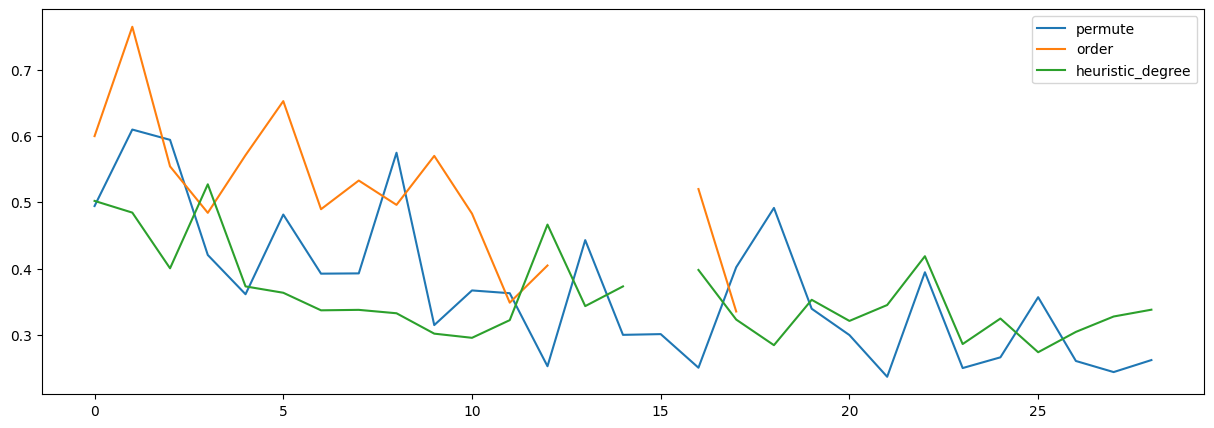

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(15,5))

plt.plot(permute[:30], label='permute')
plt.plot(ordering[:30], label='order')
plt.plot(heuristic_degree[:30], label='heuristic_degree')

plt.legend()
plt.show()

In [ ]:
fffffffffff

# Plotting

# Tests

In [ ]:
ggggggggggg

In [ ]:
it = next(iter(train_loader))
# h, mask = to_dense_batch(it.x, it.batch)
# it.x.shape, h.shape, mask.shape

In [ ]:
deg.dtype

In [ ]:
it

In [ ]:
it.edge_index[0]

In [ ]:
it.to(device)
out = model(it.x, it.pe, it.edge_index, it.edge_attr,
                    it.batch)

In [ ]:
batch = torch.tensor([0,0,0,1,1,1,1])
x = torch.tensor([0,1,2,3,4,5,6])
batch.shape, x.shape

In [ ]:
import torch

def permute_within_batch(x, batch):
    # Enumerate over unique batch indices
    unique_batches = torch.unique(batch)
    
    # Initialize list to store permuted indices
    permuted_indices = []

    for batch_index in unique_batches:
        # Extract indices for the current batch
        indices_in_batch = (batch == batch_index).nonzero().squeeze()
        
        # Permute indices within the current batch
        permuted_indices_in_batch = indices_in_batch[torch.randperm(len(indices_in_batch))]
        
        # Append permuted indices to the list
        permuted_indices.append(permuted_indices_in_batch)

    # Concatenate permuted indices into a single tensor
    permuted_indices = torch.cat(permuted_indices)

    return permuted_indices

# Example usage
batch = torch.tensor([0, 0, 0, 1, 1, 1, 1])
x = torch.tensor([0, 10, 20, 30, 40, 50, 60])

# Get permuted indices
permuted_indices = permute_within_batch(x, batch)

# Use permuted indices to get the permuted tensor
permuted_x = x[permuted_indices]

print("Original x:", x)
print("Permuted x:", permuted_x)
print("Permuted indices:", permuted_indices)


In [ ]:
mask[0].sum(), (it.batch==0).sum()

In [ ]:
self_attn = Mamba(d_model=64, # Model dimension d_model
                                d_state=16,  # SSM state expansion factor
                                d_conv=4,    # Local convolution width
                                expand=1,    # Block expansion factor
                            )
print(sum(p.numel() for p in self_attn.parameters() if p.requires_grad), sum(p.numel() for p in self_attn.parameters()))

In [ ]:
self_attn = Mamba(d_model=64, # Model dimension d_model
                                d_state=8,  # SSM state expansion factor
                                d_conv=2,    # Local convolution width
                                expand=1,    # Block expansion factor
                            )
print(sum(p.numel() for p in self_attn.parameters() if p.requires_grad), sum(p.numel() for p in self_attn.parameters()))

In [ ]:
self_attn = Mamba(d_model=64, # Model dimension d_model
                                d_state=16,  # SSM state expansion factor
                                d_conv=8,    # Local convolution width
                                expand=1,    # Block expansion factor
                            )
print(sum(p.numel() for p in self_attn.parameters() if p.requires_grad), sum(p.numel() for p in self_attn.parameters()))

In [ ]:
self_attn = torch.nn.MultiheadAttention(
                64,
                4,
                dropout=0.5,
                batch_first=True,
            )
print(sum(p.numel() for p in self_attn.parameters() if p.requires_grad), sum(p.numel() for p in self_attn.parameters()))